In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io, color, exposure
import skimage

from pathlib import Path

## Import AML APL peripheral blood cell dataset

The metadata table provides the ‘diagnosis’, ‘cohort’, ‘age at diagnosis’ and ‘gender’ for each of the participant IDs.  
Data from 106 patients are organised as folder ‘Patient_00’ to ‘Patient_105' then ‘Unsigned slides’ and ‘Signed slides’ .

In [17]:
#get path to data/main_dir
path_name = '../../data/PBC_dataset_APL_AML/'
path = Path(path_name)

In [18]:
training_glob = 'Signed slides'
validation_glob = 'Unsigned slides'

In [19]:
#create dataframe SIGNED
signed = pd.DataFrame()

signed['img_paths'] = [str(image) for image in path.rglob(f'{training_glob}/*/*.jpg')]
signed['id'] = [image.stem.split('_')[1] for image in path.rglob(f'{training_glob}/*/*.jpg')]
signed['label'] = [image.stem.split('_')[0] for image in path.rglob(f'{training_glob}/*/*.jpg')]
signed['cell_type'] = [image.parts[-2] for image in path.rglob(f'{training_glob}/*/*.jpg')]
signed['patient'] = [image.parts[3] for image in path.rglob(f'{training_glob}/*/*.jpg')]

In [20]:
signed

,img_paths,id,label,cell_type,patient
0,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828414,ERB,Erythroblast,PBC_dataset_APL_AML
1,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828371,ERB,Erythroblast,PBC_dataset_APL_AML
2,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828375,ERB,Erythroblast,PBC_dataset_APL_AML
3,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828478,ERB,Erythroblast,PBC_dataset_APL_AML
4,../../data/PBC_dataset_APL_AML/Patient_48/Sign...,13828494,ERB,Erythroblast,PBC_dataset_APL_AML
...,...,...,...,...,...
15627,../../data/PBC_dataset_APL_AML/Patient_43/Sign...,7616796,LY,Lymphocyte,PBC_dataset_APL_AML
15628,../../data/PBC_dataset_APL_AML/Patient_43/Sign...,7616831,LY,Lymphocyte,PBC_dataset_APL_AML
15629,../../data/PBC_dataset_APL_AML/Patient_43/Sign...,7616727,LY,Lymphocyte,PBC_dataset_APL_AML
15630,../../data/PBC_dataset_APL_AML/Patient_43/Sign...,7616815,LY,Lymphocyte,PBC_dataset_APL_AML


### Sort labels

`PLY`: corresponds to pro-lymphocyte for now with lymphocytes

`ERC`: corresponds to thrombocyte aggregation (difficult to see)

`PC`: to plasma cells

`GT`: giant thrombocyte

`PMO`: promonocyte for now with monocyte


In [21]:
signed.label.unique()

array(['ERB', 'VLY', 'SNE', 'PMY', 'MO', 'SMU', 'LY', 'MMY', 'BL', 'MY',
       'PC', 'GT', 'UI', 'BNE', 'EO', 'BA', 'PMO', 'ART', 'ERC', 'PLY',
       'USRWBC2'], dtype=object)

In [22]:
# Fusion of neutrophil sub-groups
signed["label"] = signed["label"].replace(to_replace = ["BNE","MY","MMY","PMY"], 
                                  value = ["IG","IG","IG","IG"])

#Fusion of lymphocyte sub-groups
signed["label"] = signed["label"].replace(to_replace = ["VLY", "PLY"], # PLY = precusor lymphocyte
                                  value = ["LY", "LY"])

#Fusion of monocyte sub-groups
signed["label"] = signed["label"].replace(to_replace = ["PMO"], 
                                  value = ["MO"])

In [23]:
signed.label.unique()

array(['ERB', 'LY', 'SNE', 'IG', 'MO', 'SMU', 'BL', 'PC', 'GT', 'UI',
       'EO', 'BA', 'ART', 'ERC', 'USRWBC2'], dtype=object)

In [24]:
signed[['label', 'cell_type']].drop_duplicates().sort_values('label')

,label,cell_type
1983,ART,Arifact
13009,ART,Monocyte
6292,BA,Metamyelocyte
13127,BA,"Blast, no lineage spec"
14461,BA,Monocyte
664,BA,Basophil
8122,BL,Promyelocyte
1358,BL,Monocyte
198,BL,"Blast, no lineage spec"
925,BL,"Lymphocyte, variant"


Some cells are classified as `unidentified` or `arifact` (Artifact) but look like blasts:  

Artifact 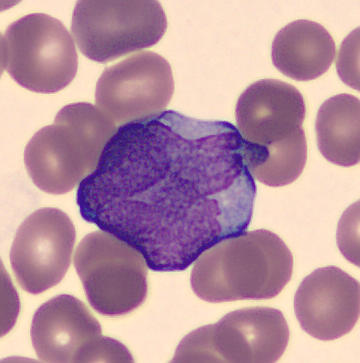 
Unidentified 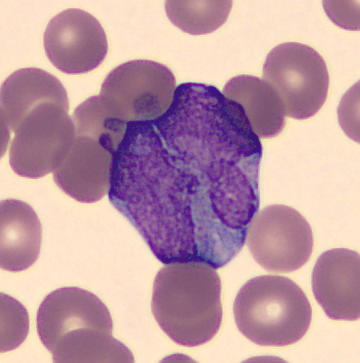 
Blast 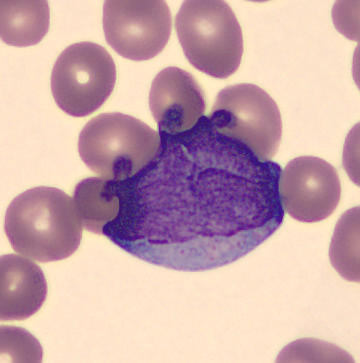

In [25]:
signed[(signed.label =='ERC')]#& (df.cell_type=='Blast, no lineage spec')]

,img_paths,id,label,cell_type,patient
5854,../../data/PBC_dataset_APL_AML/Patient_35/Sign...,13658405,ERC,Thrombocyte aggregation,PBC_dataset_APL_AML
7411,../../data/PBC_dataset_APL_AML/Patient_103/Sig...,17763339,ERC,Thrombocyte aggregation,PBC_dataset_APL_AML
7653,../../data/PBC_dataset_APL_AML/Patient_62/Sign...,13162326,ERC,Thrombocyte aggregation,PBC_dataset_APL_AML
7654,../../data/PBC_dataset_APL_AML/Patient_62/Sign...,13162023,ERC,Thrombocyte aggregation,PBC_dataset_APL_AML
7655,../../data/PBC_dataset_APL_AML/Patient_62/Sign...,13162438,ERC,Thrombocyte aggregation,PBC_dataset_APL_AML
7656,../../data/PBC_dataset_APL_AML/Patient_62/Sign...,13161970,ERC,Thrombocyte aggregation,PBC_dataset_APL_AML
7657,../../data/PBC_dataset_APL_AML/Patient_62/Sign...,13161963,ERC,Thrombocyte aggregation,PBC_dataset_APL_AML
8709,../../data/PBC_dataset_APL_AML/Patient_104/Sig...,25029618,ERC,Thrombocyte aggregation,PBC_dataset_APL_AML
8710,../../data/PBC_dataset_APL_AML/Patient_104/Sig...,25029619,ERC,Thrombocyte aggregation,PBC_dataset_APL_AML
8711,../../data/PBC_dataset_APL_AML/Patient_104/Sig...,25029617,ERC,Thrombocyte aggregation,PBC_dataset_APL_AML


# TO DO clean up cell

In [26]:
%time

for file in signed['img_paths']:
    try:
        im = io.imread(file)
        
    except ValueError:
        print(file)
        signed = signed[~(signed['img_paths'] == file)] #remove truncated image

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
../../data/PBC_dataset_APL_AML/Patient_30/Signed slides/Smudge cells/SMU_8371935.jpg
../../data/PBC_dataset_APL_AML/Patient_52/Signed slides/Lymphocyte/LY_8338724.jpg
../../data/PBC_dataset_APL_AML/Patient_24/Signed slides/Blast, no lineage spec/BL_7821735.jpg
../../data/PBC_dataset_APL_AML/Patient_58/Signed slides/Smudge cells/SMU_15364290.jpg
../../data/PBC_dataset_APL_AML/Patient_36/Signed slides/Blast, no lineage spec/BL_7744281.jpg
../../data/PBC_dataset_APL_AML/Patient_99/Signed slides/Smudge cells/SMU_17364544.jpg
../../data/PBC_dataset_APL_AML/Patient_37/Signed slides/Blast, no lineage spec/BL_6611696.jpg


In [27]:
images = [io.imread(file) for file in signed['img_paths']]
len(images)

15625

### Add height, width and brightness to df

In [28]:
signed['height'] = [im.shape[0] for im in images]
signed['width'] = [im.shape[1] for im in images]

In [29]:
signed['mean_brightness'] = [np.mean(im) for im in images]

In [31]:
signed.to_csv('../../data/PBC_dataset_AML_APL.csv', index=False)